In [1]:
!pip install plotly
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import plotly.graph_objects as go

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


## Description of the STIRAP class

In the below cell is the definition for <code>class STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiency_of_guess()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot_for_guess(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.krotov_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses of intensity with phase and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Krotov's method](https://qucontrol.github.io/krotov/v1.2.1/07_krotovs_method.html).

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on three variables, the end time of the stokes pulse and start time of pump pulse and the two photon detuning ($\delta$).

In [2]:
class STIRAP():
    def __init__(self,Omega_S,Omega_P,E1,E2,E3,T,tS1,tS2,tP1,tP2,Δ=0,Gamma=0,delta=0,lam=1):
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.tS1 = tS1*T
        self.tS2 = tS2*T
        self.tP1 = tP1*T
        self.tP2 = tP2*T
        self.Δ = Δ - (0.5j*Gamma)
        self.efficiency = 0
        self.delta = delta
        self.lam = lam
    
    def _Omega_P1(self,t, args):
        return self.Ω_P*krotov.shapes.blackman(t, t_start=self.tP1, t_stop=self.tP2)

    def _Omega_P2(self,t, args):
        return 0.0

    def _Omega_S1(self,t, args):
        return self.Ω_S*krotov.shapes.blackman(t, t_start=self.tS1, t_stop=self.tS2)
    
    def _Omega_S2(self,t, args):
        return 0.0
    
    def _hamiltonian(self):
        # detunings
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = Qobj([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HP_im = 0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        HS_im = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])
        return [H0,[HP_re, self._Omega_P1],[HP_im, self._Omega_P2],[HS_re, self._Omega_S1],[HS_im, self._Omega_S2],]
    
    def _final_result(self):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self._hamiltonian())
        tlist = np.linspace(0, self.T, 500)
        result = objective.mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        self.efficiency = result.expect[2][-1]
        return result,self.efficiency
    
    def efficiency_of_guess(self):
        return self._final_result()[1]
    
    def _neg_eff(self,x):
        self.tS2 = x[0]*self.T
        self.tP1 = x[1]*self.T
        self.delta = x[2]/self.T
        return -1*self.efficiency_of_guess()
        
    def plot_for_guess(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        result,_ = self._final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, 500)
        pulse = tlist
        if callable(self._Omega_P1) and callable(self._Omega_S1):
            pulse1 = np.array([self._Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self._Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def _shape(self,t):
        return krotov.shapes.flattop(t, t_start=0.0, t_stop=self.T, t_rise=self.T*0.2, func='sinsq')
    
    def _plot_pulse_amplitude_and_phase(self,pulse_real, pulse_imaginary,tlist):
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
        phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
        ax1.plot(tlist,amplitudes)
        ax1.set_xlabel('time')
        ax1.set_ylabel('pulse amplitude')
        ax2.plot(tlist,phases)
        ax2.set_xlabel('time')
        ax2.set_ylabel('pulse phase (π)')
        plt.show()
       
    def _krotov_optimization_routine(self):
        tlist = np.linspace(0, self.T, 500)
        H = self._hamiltonian()
        pulse_options = {
            H[1][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[2][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[3][1]: dict(lambda_a=self.lam, update_shape=self._shape),
            H[4][1]: dict(lambda_a=self.lam, update_shape=self._shape)}
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self._hamiltonian())
        opt_result = krotov.optimize_pulses([objective],pulse_options,tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=krotov.functionals.chis_re,
            info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re,show_g_a_int_per_pulse=True,unicode=False,),
            check_convergence=krotov.convergence.Or(
            krotov.convergence.value_below(1e-3, name='J_T'),krotov.convergence.delta_below(1e-5),krotov.convergence.check_monotonic_error,),
            iter_stop=15,)
        return opt_result
    
    def _print_opti_pulse(self,opt_result):
        tlist = np.linspace(0, self.T, 500)
        print("pump pulse amplitude and phase:")
        self._plot_pulse_amplitude_and_phase(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
        print("Stokes pulse amplitude and phase:")
        self._plot_pulse_amplitude_and_phase(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)
        
    def krotov_opti_result(self,print_pulse=True):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        tlist = np.linspace(0, self.T, 500)
        optimized = self._krotov_optimization_routine()
        if print_pulse:
            self._print_opti_pulse(optimized)
        result = optimized.optimized_objectives[0].mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
        
    def scipy_opti_result(self,print_pulse=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.array([self.tS2,self.tP1,self.delta*self.T]), args=(), method='Powell', #bounds = [(0.1,1),(0,0.9),(-40,40)],
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10, 'disp': True})
        print(opti)
        self.tS2 = opti.x[0]*self.T
        self.tP1 = opti.x[1]*self.T
        if print_pulse:
            self.plot_for_guess()

### Example 1
Below is the simulation with both pulses having peak of 31.6 MHz and full overlap over a width of 20 $\mu s$. The single photon detuning is $\Delta = 1$ GHz and there is two photon resonance.

Efficiency = 0.9974486785809751


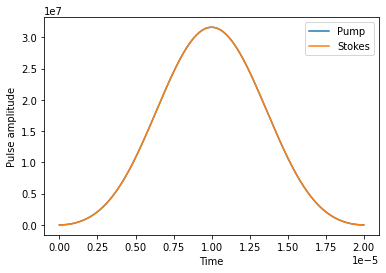

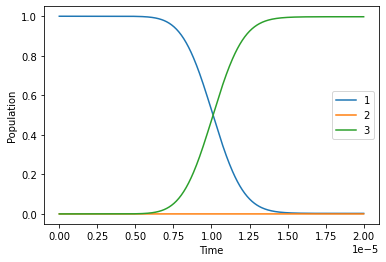

In [13]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=20*10**(-6),tS1=0,tS2=1,tP1=0,tP2=1,Δ=10**9)
print("Efficiency = "+str(try_1.efficiency_of_guess()))
try_1.plot_for_guess()

### Example 2
In this example we use with unequal peaks of 100 MHz peak for stokes and 10 MHz peak for pump. We use the scipy optimization to pick the optimal $\delta$, and the start time for pump and end for stokes. The ideal stokes end time comes to be larger than the total time but this is effective of it getting cut at the completion of $T$ since beyond that there would be no changes.

In [ ]:
try_2 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=2.5*10**(-5),tS1=0,tS2=0.8,tP1=0.14,tP2=1,Δ=10**9,delta=2.088*10**6)
try_2.scipy_opti_result()
print("Efficiency = "+str(try_2.efficiency_of_guess()))

### Example 3
In the following example we use the same peaks as the previous one but this time use a different guess and try and see whether we can optimize with krotov. The krotov optimization however performs very poorly and with a little analysis this seems to be an occurence for large detuning case in specefic as it is able to optimize when the detuning is of the same scale as the rabi peaks and time scale is appropriate.

In [ ]:
try_ = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=1,tP1=0,tP2=1,Δ=10**9,Gamma=0*6*10**6,delta=2.088*10**6)
print("Efficiency = "+str(try_2.efficiency_of_guess([1,0])))
try_2.plot_for_guess()

In [ ]:
try_2.krotov_opti_result()

In [71]:
points = 20
x_range = np.linspace(0.8,1.5,points)
y_range = np.linspace(0.1,0.4,points)
X,Y = np.meshgrid(x_range, y_range)
Z = [[-1 for i in range(points)] for j in range(points)]
for i in range(len(Y)):
    for j in range(len(X)):
        try_4 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=x_range[j],tP1=y_range[i],tP2=1,Δ=10**9,delta=2182237.5052)
        Z[i][j] = try_4.efficiency_of_guess()
    print("Progress\t"+str(i)+"/"+str(points)+"\t Last: "+str(Z[i][j]))
Z = np.array(Z)

Progress	0/20	 Last: 0.6525790523249291
Progress	1/20	 Last: 0.6771117914455783
Progress	2/20	 Last: 0.7016942575885716
Progress	3/20	 Last: 0.72615443023621
Progress	4/20	 Last: 0.7503663295896933
Progress	5/20	 Last: 0.7740339136672514
Progress	6/20	 Last: 0.7970638306886216
Progress	7/20	 Last: 0.8191417247153034
Progress	8/20	 Last: 0.8401209673858051
Progress	9/20	 Last: 0.8596266299163142
Progress	10/20	 Last: 0.8774970056567768
Progress	11/20	 Last: 0.8932926478631465
Progress	12/20	 Last: 0.9067452746876674
Progress	13/20	 Last: 0.91751252862742
Progress	14/20	 Last: 0.9253147575560237
Progress	15/20	 Last: 0.9299428278498149
Progress	16/20	 Last: 0.9313362117715879
Progress	17/20	 Last: 0.9294039285329606
Progress	18/20	 Last: 0.9241582745314045
Progress	19/20	 Last: 0.915731870353911


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


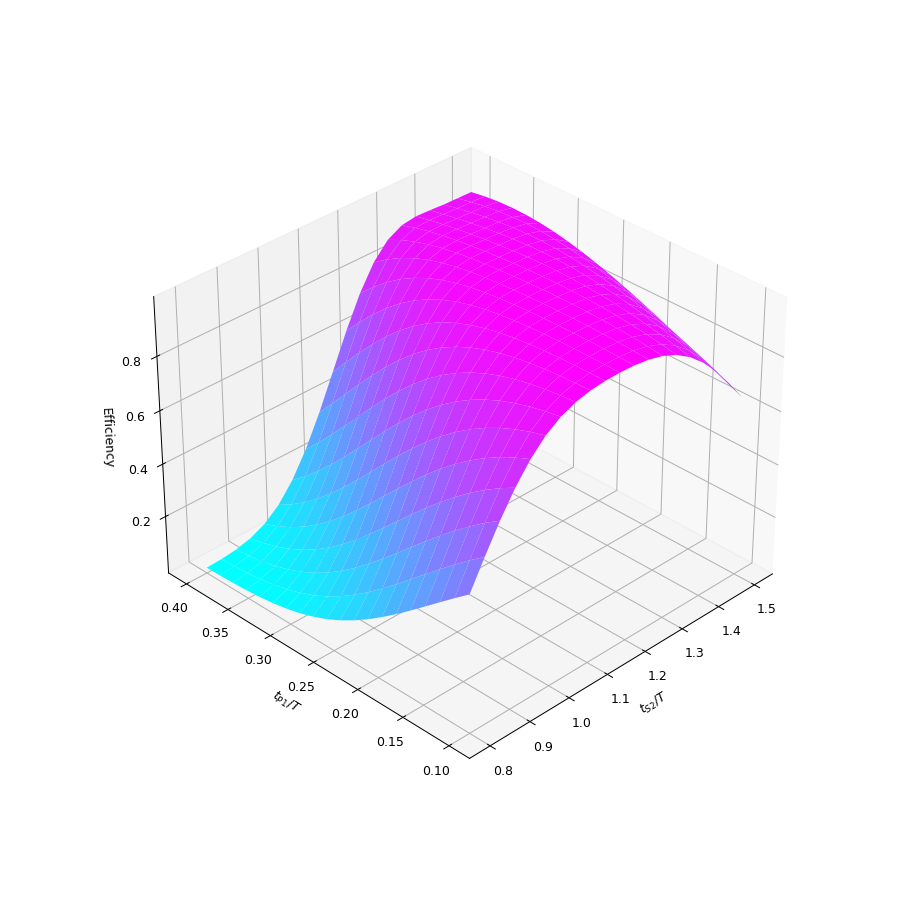

In [75]:
%notify -m "Check the notebook man"
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
from mpl_toolkits.mplot3d import axes3d
def Plot3dim(x,y,z):
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z,cmap='cool')
#     ax.axes.set_xlim3d(left=min(x), right=max(x)) 
#     ax.axes.set_ylim3d(bottom=min(y), top=max(y)) 
    ax.grid(True)
    ax.set_xlabel(r"$t_{S2}/T$")
    ax.set_ylabel(r"$t_{P1}/T$")
    ax.set_zlabel(r"Efficiency")
%matplotlib notebook
Plot3dim(X,Y,Z)

0.0


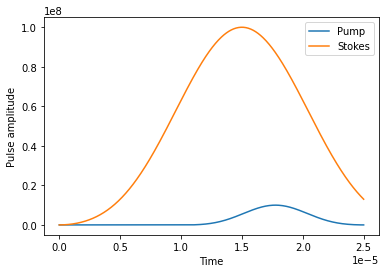

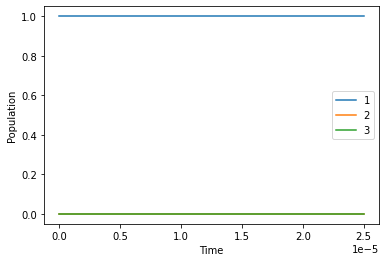

In [51]:
try_4 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=1.2,tP1=0.42026269,tP2=1,Δ=10**9,delta=2182237.5052)
print(try_4.efficiency_of_guess())
try_4.plot_for_guess()

Optimization terminated successfully.
         Current function value: -0.006117
         Iterations: 4
         Function evaluations: 153
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.51716223e-02,  7.33885529e-04,  3.87001008e-03],
       [-4.25439701e-03, -6.30586775e-03, -1.22785284e-02]])
     fun: -0.006116671169199509
 message: 'Optimization terminated successfully.'
    nfev: 153
     nit: 4
  status: 0
 success: True
       x: array([ 1.06300885, -0.06254731,  1.80533248])
Optimization terminated successfully.
         Current function value: -0.101709
         Iterations: 4
         Function evaluations: 147
   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-1.25868182e-02,  1.63983531e-04,  8.29312795e-03],
       [-1.09504561e-02, -7.63583859e-03,  2.26183065e-03]])
     fun: -0.10170891288347816
 message: 'Optimization terminated successfully.'
    nfev: 147
     nit: 4
  status: 0
 success: True
       x: arra

<IPython.core.display.Javascript object>


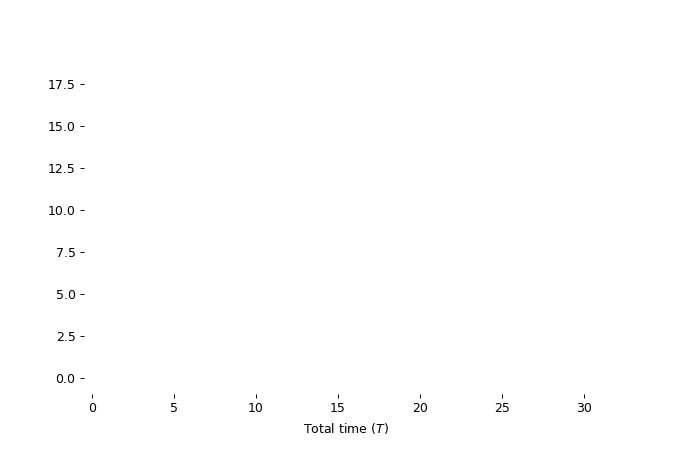

Text(0, 0.5, 'Optimized efficiency')

In [77]:
times = np.linspace(1,30,10)
effi_T = []
for T in times:
    try_5 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=T*10**(-6),tS1=0,tS2=0.9,tP1=0.4,tP2=1,Δ=10**9,delta=2*10**6)
    try_5.scipy_opti_result(False)
    effi_T.append(try_5.efficiency_of_guess())
fig, ax = plt.subplots()
ax.plot(times, effi_T)
ax.set_xlabel('Total time ($T$)')
ax.set_ylabel('Optimized efficiency')

Text(0, 0.5, '$-\\log_{10} (1-$efficiency)')

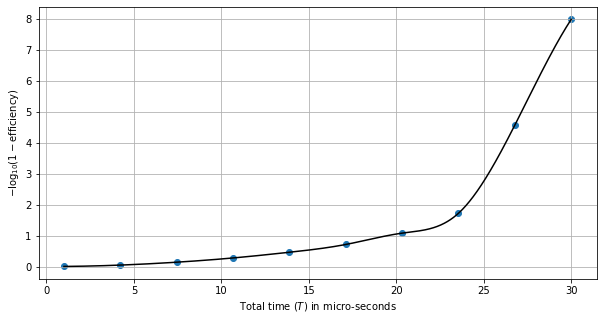

In [99]:
effi_T = np.array(effi_T)
def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
x_times = np.linspace(1,30,1000)
logs = eff_interpolated(x_times,times,-np.log(1-effi_T)/np.log(10))


fig, ax = plt.subplots()
plt.gcf().set_size_inches(10,5)
# %matplotlib inline
ax.scatter(times,-np.log(1-effi_T)/np.log(10))
ax.plot(x_times,logs,color='black')
ax.grid(True)
ax.set_xlabel('Total time ($T$) in micro-seconds')
ax.set_ylabel('$-\log_{10} (1-$efficiency)')

In [11]:
Z1 = np.load("efficiencies.npy")
sh_0, sh_1 = Z1.shape
X1, Y1 = np.linspace(0.8, 1.5, sh_0), np.linspace(0.1, 0.6, sh_1)
fig = go.Figure(data=[go.Surface(z=Z1, x=X1, y=Y1)])
fig.update_layout(title='Variation of efficiencies',#autosize=False,
                  width=1000, height=700,
                  margin=dict(l=65, r=50, b=65, t=90)
                 )
fig.show()

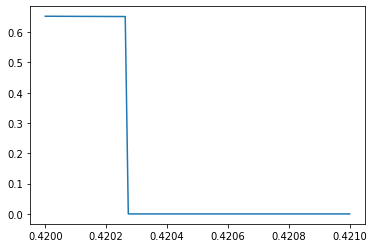

In [16]:
#Get an idea of the sudden fall
tp1_range = np.linspace(0.42,0.421,100)
effi_tp1 = []
for tp1 in tp1_range:
    try_6 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=1.2,tP1=tp1,tP2=1,Δ=10**9,delta=2182237.5052)
    effi_tp1.append(try_6.efficiency_of_guess())
plt.plot(tp1_range,effi_tp1)

In [21]:
for i in range(len(effi_tp1)):
    if effi_tp1[i]==0:
        print(tp1_range[i])
        break

0.42027272727272724
